**Explanation**

## Bipartite Ranking Algorithm
This notebook implements a bipartite ranking algorithm that ranks items based on user ratings while iteratively refining user reputations. The goal is to achieve a fair ranking system where user biases are minimized.

### **How it Works**
1. **Initialize User Reputation**: All users start with equal reputation.
2. **Compute Item Rankings**: Item scores are calculated using weighted user ratings.
3. **Update User Reputation**: Users with large rating errors are penalized.
4. **Iterate Until Convergence**: The process is repeated until rankings stabilize.

This notebook will:
- Load the dataset.
- Apply the bipartite ranking algorithm.
- Visualize the resulting item rankings.




**1.    Imports**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import csv
from collections import defaultdict

**2.    Load Dataset**


In [10]:
# Define dataset path
file_path = "/home/martimsbaltazar/Desktop/tese/datasets/BookCrossing/Shortened_Ratings.csv"

df = pd.read_csv(file_path, sep=',')

# Rename columns
df.columns = ['user_id', 'item_id', 'normalized_rating']

# Normalize the rating
df['normalized_rating'] = df['normalized_rating'] / 10

# Display first few rows
df.head()

all_users = set(df["user_id"].unique())

item_raters = defaultdict(set)

for item_id, user_id in zip(df['item_id'], df['user_id']):
    item_raters[item_id].add(user_id)

**3.    Bipartite Ranking Algorithm**

In [4]:
def bipartite_ranking_algorithm(df, lambda_factor=0.3, tol=1e-6, max_iter=50):
    users = df["user_id"].unique()
    items = df["item_id"].unique()

    # Preprocess: Group ratings by item and user
    item_to_ratings = dict(tuple(df.groupby("item_id")))
    user_to_ratings = dict(tuple(df.groupby("user_id")))

    # Step 1: Initialize user reputations (equal for all users)
    user_reputation = {user: 1.0 for user in users}
    prev_total_ranking = None

    for iteration in range(max_iter):
        # Step 2: Update item rankings
        item_rankings = {}
        for item in items:
            if item not in item_to_ratings:
                continue

            item_ratings = item_to_ratings[item]
            users_who_rated = item_ratings["user_id"].values
            ratings = item_ratings["normalized_rating"].values

            if len(users_who_rated) == 0:
                continue

            weighted_sum = sum(
                float(user_reputation[u]) * float(r)
                for u, r in zip(users_who_rated, ratings)
            )
            total_weight = len(users_who_rated)

            item_rankings[item] = weighted_sum / total_weight if total_weight > 0 else 0

        # Step 5: Update user reputations
        for user in users:
            if user not in user_to_ratings:
                continue

            user_ratings = user_to_ratings[user]
            items_rated = user_ratings["item_id"].values
            ratings = user_ratings["normalized_rating"].values

            if len(items_rated) == 0:
                continue

            rating_errors = [
                abs(r - item_rankings[i]) for i, r in zip(items_rated, ratings)
                if i in item_rankings
            ]
            if not rating_errors:
                continue

            avg_error = sum(rating_errors) / len(rating_errors)
            user_reputation[user] = max(1 - lambda_factor * avg_error, 0)

        # Step 8: Check for convergence based on total ranking score
        total_ranking = sum(item_rankings.values())
        if prev_total_ranking is not None:
            if abs(total_ranking - prev_total_ranking) < tol:
                break
        prev_total_ranking = total_ranking

    return item_rankings, user_reputation


**4. Compute Item Rankings**


In [5]:
rankings, userReputation = bipartite_ranking_algorithm(df)

print(userReputation)


{44: 0.9317240901573133, 160: 0.9542147398879066, 199: 0.9842061405162615, 242: 0.9597935074234896, 384: 0.9467887367392548, 387: 0.9151363658347325, 392: 0.9937174634942939, 424: 0.9059702378605404, 444: 0.9433778618557997, 505: 0.904567302040758, 638: 0.8786840592203324, 651: 0.9422935293050674, 712: 0.9414862031779037, 735: 0.9031792785960919, 741: 0.9555737455396967, 746: 0.9398393659728977, 776: 0.8919620475703481, 777: 0.9132039944175985, 805: 0.9082915232357547, 843: 0.929964320805464, 853: 0.9147872644897062, 876: 0.9714140705840351, 882: 0.9202932340308049, 900: 0.9417123694773363, 901: 0.9545988973819686, 914: 0.9781430371506725, 945: 1.0, 989: 0.9908661835217691, 1113: 0.9487793149419738, 1129: 0.9336480266806939, 1131: 0.9087782625609915, 1155: 0.9087784668653444, 1178: 0.9910161841077272, 1254: 0.9233093231558885, 1297: 0.9488129705934392, 1348: 0.9661642613314714, 1409: 0.8321013816002409, 1435: 0.943581344270336, 1466: 0.9626680814769507, 1548: 0.8983160651124129, 1585: 

**5. Visualizing the Distribution of Item Rankings**

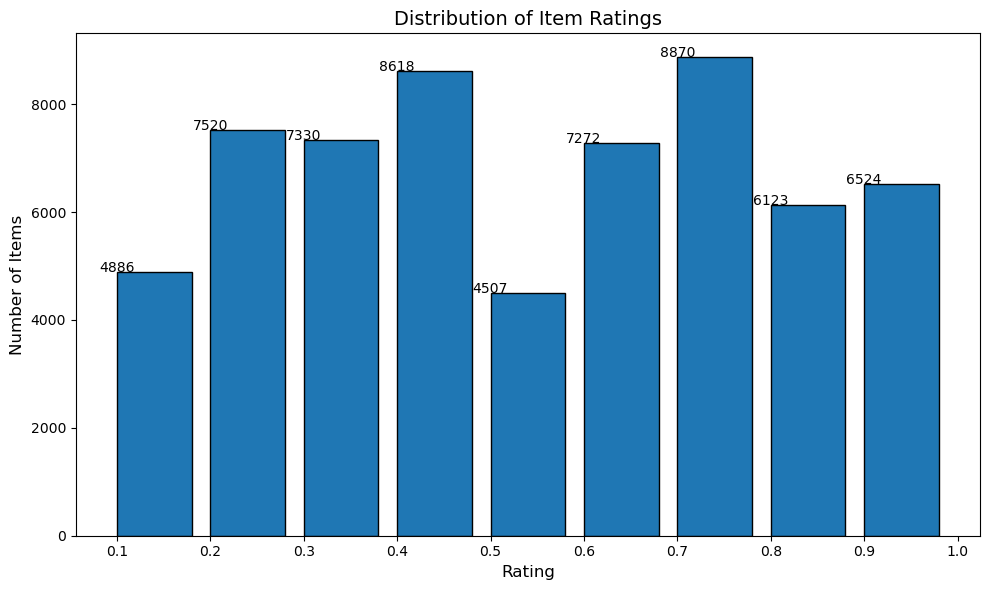

In [6]:
# Extract the ratings from the rankings
ratings = list(rankings.values())

# Define bins for the ratings (from 0.1 to 1.0 with steps of 0.1)
bins = np.arange(0.1, 1.1, 0.1)

# Count how many items fall into each rating bin
hist, bin_edges = np.histogram(ratings, bins=bins)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(hist)):
    plt.text(bin_edges[i], hist[i] + 1, str(hist[i]), ha='center', fontsize=10)

# Finalize the plot
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.title('Distribution of Item Ratings', fontsize=14)
plt.xticks(bins)  # Ensure the x-ticks correspond to the rating bins
plt.tight_layout()
plt.show()


**6. Demographics**


In [7]:
file_path = "/home/martimsbaltazar/Desktop/tese/datasets/BookCrossing/Shortened_Users.csv"

# Load the file
demographics = pd.read_csv(file_path,sep=",")
print(demographics.columns)
# Strip column names to remove extra whitespace
demographics.columns = demographics.columns.str.strip()

# Convert Age to numeric, coercing non-numeric entries to NaN
demographics['Age'] = pd.to_numeric(demographics['Age'], errors='coerce')

# Drop rows where Age is NaN (non-integer or missing)
demographics = demographics.dropna(subset=['Age'])

# Convert to integer (now safe to do)
demographics['Age'] = demographics['Age'].astype(int)
demographics['User-ID'] = demographics['User-ID'].astype(int)

# Define age ranges
age_ranges = {
    "< 18": lambda age: age < 18,
    "18-24": lambda age: 18 <= age <= 24,
    "25-34": lambda age: 25 <= age <= 34,
    "35-44": lambda age: 35 <= age <= 44,
    "45-54": lambda age: 45 <= age <= 54,
    ">= 55": lambda age: age >= 55,
}

# Create age group buckets
age_groups = defaultdict(set)

# Populate groups
for _, row in demographics.iterrows():
    user_id = row['User-ID']
    age = row['Age']
    for label, condition in age_ranges.items():
        if condition(age):
            age_groups[label].add(user_id)
            break

# Print result summary
for group, users in age_groups.items():
    print(f"{group}: {len(users)} users")



Index(['User-ID', 'Age'], dtype='object')
45-54: 822 users
18-24: 792 users
35-44: 1428 users
< 18: 256 users
25-34: 2100 users
>= 55: 602 users


**7. Metrics**


**7.1   Effectiveness**

In [8]:
def compute_aggregated_average_ranking(df):
    return df.groupby("item_id")["normalized_rating"].mean().to_dict()

def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Ensure only common items are compared
    
    if len(common_items) < 2:  # Need at least two rankings to compute Kendall's tau
        return 0
    
    sorted_items = sorted(common_items)  # Sort items to ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

# Compute the aggregated average ranking
aa_rankings = compute_aggregated_average_ranking(df)

# Compute Kendall’s tau for the entire dataset
tau_value = compute_kendall_tau(rankings, aa_rankings)
print(f"Kendall’s τ: {tau_value:.4f}")



Kendall’s τ: 0.9894


**6.2   Bias**

In [11]:
def demographic_reputation_gap(group_users, user_reputations):
    target_users = group_users & all_users
    complementary_users = all_users - target_users

    target_reps = [user_reputations[u] for u in target_users]
    comp_reps = [user_reputations[u] for u in complementary_users]

    target_avg = sum(target_reps) / len(target_reps) if target_reps else 0
    comp_avg = sum(comp_reps) / len(comp_reps) if comp_reps else 0

    return target_avg - comp_avg

# --------------------------------------------------
# AGE GROUP GAPS
print("\n=== Age-Based Reputation Gaps ===")
gap = demographic_reputation_gap(age_groups["< 18"], userReputation)
print(f"Reputation gap (< 18 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["18-24"], userReputation)
print(f"Reputation gap (18-24 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["25-34"], userReputation)
print(f"Reputation gap (25-34 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["35-44"], userReputation)
print(f"Reputation gap (35-44 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["45-54"], userReputation)
print(f"Reputation gap (45-54 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups[">= 55"], userReputation)
print(f"Reputation gap (>= 55 vs rest): {gap:.4f}")



=== Age-Based Reputation Gaps ===
Reputation gap (< 18 vs rest): 0.0013
Reputation gap (18-24 vs rest): 0.0010
Reputation gap (25-34 vs rest): -0.0001
Reputation gap (35-44 vs rest): 0.0025
Reputation gap (45-54 vs rest): -0.0009
Reputation gap (>= 55 vs rest): -0.0056
